# Intermediate Representation (IR)

## Set up

In [20]:
import os
import networkx as nx
import re
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import save_npz
import numpy as np


In [21]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data')
NAME = 'crpwarner'
IN_PATH = os.path.join(DATA_PATH, f'external/{NAME}/groundtruth/out')
OUT_PATH = os.path.join(DATA_PATH, f'interim/{NAME}')
PRO_PATH = os.path.join(DATA_PATH, 'processed/ir_gigahorse')
df = pd.read_csv(os.path.join(OUT_PATH, 'dataset-modified.csv')).set_index('address')

## Feature Extraction

In [22]:
def facts_to_nx(edges, opcodes):
    # load edges
    G = nx.DiGraph()
    G.add_edges_from(edges.values)

    for _, row in opcodes.iterrows():
        if row["stmt"] in G:
            G.nodes[row["stmt"]]["opcode"] = row["opcode"]
        else:
            G.add_node(row["stmt"], opcode=row["opcode"])
    return G

In [23]:
def extract_graph_features(G):
    return {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "density": nx.density(G),
        "connected_components": nx.number_weakly_connected_components(G),
        "avg_clustering": nx.average_clustering(G.to_undirected())
    }


## Extract Feature from Gigahorse's Result

- Graph
- TF-IDF
- N-Grams
- Freq

In [24]:
# Get all filenames in IN_PATH without a dot, converted to lowercase
# files = [x.lower() for x in os.listdir(IN_PATH) if '.' not in x]
# files

records = []
grouping = []

documents_opcode_seq = []
documents_grouping_opcode_seq = []

opcode_seq_n_grams = []
grouping_opcode_seq_n_grams = []

addresses_hex = []

graphs = []
labels = []
graph_stats = []

for directory in os.listdir(IN_PATH):
    if '.' not in directory:
        address = directory.lower()
        opcode_path = os.path.join(IN_PATH, f"{directory}/Statement_Opcode.facts")
        edge_path = os.path.join(IN_PATH, f"{directory}/Statement_Next.facts")
        edges = pd.read_csv(edge_path, sep="\t", header=None, names=["src", "dst"])
        op_df = pd.read_csv(opcode_path, sep="\t", header=None, names=["stmt", "opcode"])

        opcodes = op_df["opcode"].tolist()
        freq = dict(Counter(opcodes))
        freq['address'] = address

        grouping_opcode = []

        for opcode in opcodes:
            match = re.match(r'^[a-zA-Z]+', opcode)

            if match:
                opcode_group = match.group()
                grouping_opcode.append(opcode_group)
            else:
                grouping_opcode.append(opcode)

        grouping_freq = dict(Counter(grouping_opcode))
        grouping_freq['address'] = address

        records.append(freq)
        grouping.append(grouping_freq)

        if address in df.index:
            seq_freq = dict()
            grouping_seq_freq = dict()
            opcode_seq = " ".join(opcodes)
            grouping_opcode_seq = " ".join(grouping_opcode)
            documents_opcode_seq.append(opcode_seq)
            documents_grouping_opcode_seq.append(grouping_opcode_seq)
            addresses_hex.append(address)
            seq_freq['opcode_sequence'] = opcode_seq
            seq_freq['address'] = address
            grouping_seq_freq['opcode_sequence'] = grouping_opcode_seq
            grouping_seq_freq['address'] = address
            opcode_seq_n_grams.append(seq_freq)
            grouping_opcode_seq_n_grams.append(grouping_seq_freq)

            nx_graph = facts_to_nx(edges, op_df)
            feats = extract_graph_features(nx_graph)
            feats['address'] = address
            graph_stats.append(feats)
            graphs.append(nx_graph)
            label_row = df.loc[address]
            labels.append(label_row.to_dict())

feature_df = pd.DataFrame(records).fillna(0).set_index('address')
grouping_feature_df = pd.DataFrame(grouping).fillna(0).set_index('address')
seq_df = pd.DataFrame(opcode_seq_n_grams).fillna(0).set_index('address')
grouping_seq_df = pd.DataFrame(grouping_opcode_seq_n_grams).fillna(0).set_index('address')

vectorizer = CountVectorizer(ngram_range=(2, 3), analyzer='word', max_features=1000)
X_ngrams = vectorizer.fit_transform(seq_df['opcode_sequence'])

n_gram_feature_df = pd.DataFrame(X_ngrams.toarray(), columns=vectorizer.get_feature_names_out())
n_gram_feature_df['address'] = seq_df.index
n_gram_feature_df = n_gram_feature_df.set_index('address')

grouping_vectorizer = CountVectorizer(ngram_range=(2, 3), analyzer='word', max_features=1000)
grouping_X_ngrams = grouping_vectorizer.fit_transform(grouping_seq_df['opcode_sequence'])

grouping_n_gram_feature_df = pd.DataFrame(grouping_X_ngrams.toarray(), columns=grouping_vectorizer.get_feature_names_out())
grouping_n_gram_feature_df['address'] = grouping_seq_df.index
grouping_n_gram_feature_df = grouping_n_gram_feature_df.set_index('address')

graph_stat_feature_df = pd.DataFrame(graph_stats).fillna(0).set_index('address')

In [25]:
feature_df.head()

,PUSH1,MSTORE,CALLVALUE,DUP1,ISZERO,PUSH2,JUMPI,REVERT,JUMPDEST,POP,...,PUSH17,EXTCODECOPY,SWAP13,CALLCODE,PUSH31,DUP15,SIGNEXTEND,CREATE,DUP16,LOG0
address,,,,,,,,,,,,,,,,,,,,,
0x51c5807dd8398aedfcc91e6483417838b41eaeb8,264,77.0,1.0,91,20.0,116.0,36,15,72,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x8275ebf521dc217aa79c88132017a5bcef001dd9,386,112.0,15.0,173,78.0,126.0,53,25,101,158.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe4182e57eeb29fbc2b3469e45c9e385cea8995ab,1116,301.0,2.0,343,115.0,314.0,145,67,254,280.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x28c748535cc0c774d7bb046adba0c9d77e3b4c92,314,78.0,1.0,75,18.0,136.0,47,15,96,55.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a,515,148.0,1.0,260,70.0,227.0,69,24,156,246.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
grouping_feature_df.head()

,PUSH,MSTORE,CALLVALUE,DUP,ISZERO,JUMPI,REVERT,JUMPDEST,POP,CALLDATASIZE,...,DIFFICULTY,COINBASE,EXTCODEHASH,BASEFEE,MULMOD,BYTE,DELEGATECALL,EXTCODECOPY,CALLCODE,SIGNEXTEND
address,,,,,,,,,,,,,,,,,,,,,
0x51c5807dd8398aedfcc91e6483417838b41eaeb8,418,77.0,1.0,302,20.0,36,15,72,65.0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x8275ebf521dc217aa79c88132017a5bcef001dd9,674,112.0,15.0,446,78.0,53,25,101,158.0,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe4182e57eeb29fbc2b3469e45c9e385cea8995ab,1658,301.0,2.0,1144,115.0,145,67,254,280.0,18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x28c748535cc0c774d7bb046adba0c9d77e3b4c92,500,78.0,1.0,251,18.0,47,15,96,55.0,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xdf7ff95aa3d855a6fb21399432166a92fdcf1b1a,915,148.0,1.0,654,70.0,69,24,156,246.0,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


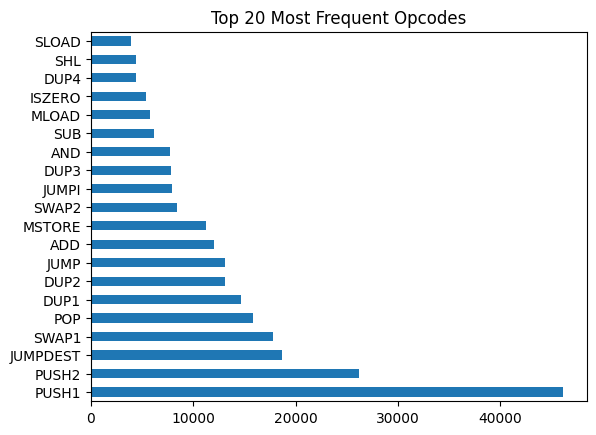

In [27]:
feature_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Most Frequent Opcodes")
plt.show()

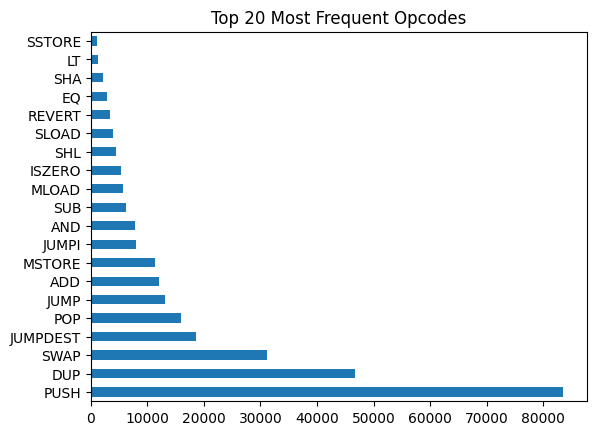

In [28]:
grouping_feature_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Most Frequent Opcodes")
plt.show()

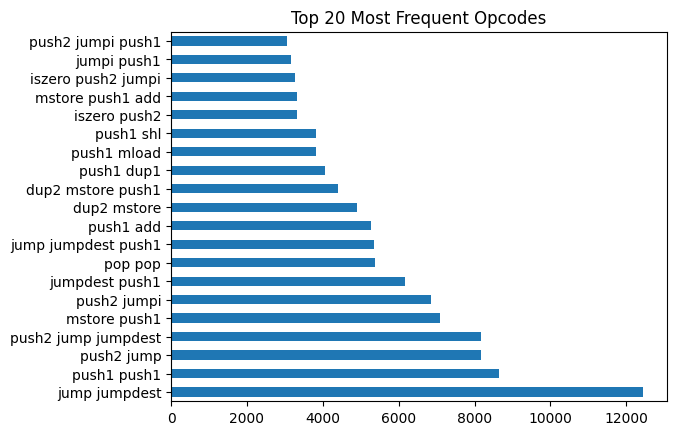

In [29]:
n_gram_feature_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Most Frequent Opcodes")
plt.show()

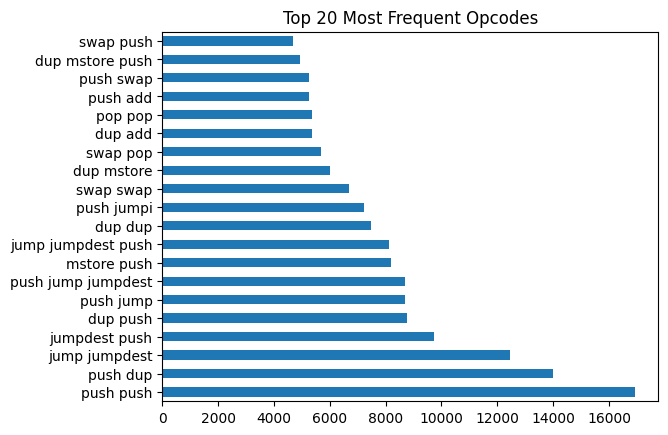

In [30]:
grouping_n_gram_feature_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title("Top 20 Most Frequent Opcodes")
plt.show()

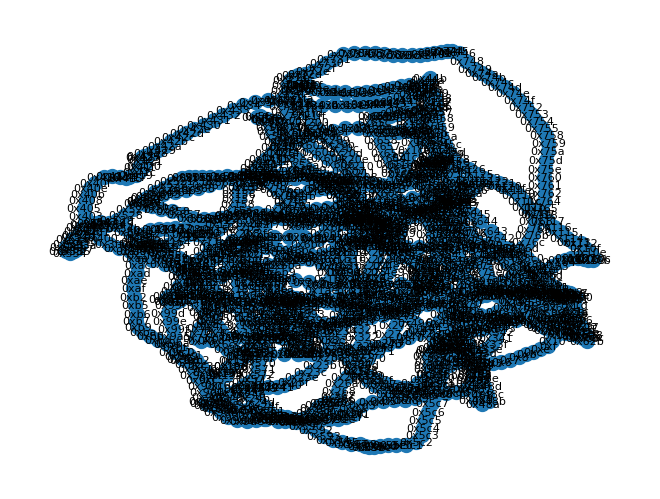

In [31]:
nx.draw(graphs[0], with_labels=True, node_size=100, font_size=8)
plt.show()

In [32]:
labels_col = list(df.columns)
features = list(feature_df.columns)
grouping = list(grouping_feature_df)
with open(os.path.join(PRO_PATH, 'labels.json'), "w") as f:
    json.dump(labels_col, f, indent=2)

with open(os.path.join(PRO_PATH, 'features.json'), "w") as f:
    json.dump(features, f, indent=2)

with open(os.path.join(PRO_PATH, 'grouping_features.json'), "w") as f:
    json.dump(grouping, f, indent=2)

In [33]:
feature_df = df.merge(feature_df, left_index=True, right_index=True)
feature_df.select_dtypes(float).fillna(0).astype(int)
feature_df.head()

,mint,leak,limit,PUSH1,MSTORE,CALLVALUE,DUP1,ISZERO,PUSH2,JUMPI,...,PUSH17,EXTCODECOPY,SWAP13,CALLCODE,PUSH31,DUP15,SIGNEXTEND,CREATE,DUP16,LOG0
address,,,,,,,,,,,,,,,,,,,,,
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,660,176.0,1.0,118,33.0,378.0,101,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,16,2.0,1.0,5,2.0,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,489,107.0,22.0,160,68.0,469.0,96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,725,150.0,22.0,206,104.0,694.0,115,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,0,940,198.0,35.0,250,110.0,447.0,167,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
grouping_feature_df = df.merge(grouping_feature_df, left_index=True, right_index=True)
grouping_feature_df.select_dtypes(float).fillna(0).astype(int)
grouping_feature_df.head()

,mint,leak,limit,PUSH,MSTORE,CALLVALUE,DUP,ISZERO,JUMPI,REVERT,...,DIFFICULTY,COINBASE,EXTCODEHASH,BASEFEE,MULMOD,BYTE,DELEGATECALL,EXTCODECOPY,CALLCODE,SIGNEXTEND
address,,,,,,,,,,,,,,,,,,,,,
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,1156,179.0,1.0,517,33.0,101,23,...,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,21,3.0,1.0,7,2.0,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,1135,107.0,22.0,585,68.0,96,38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,1623,150.0,22.0,890,104.0,115,52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,0,1503,198.0,35.0,664,110.0,167,67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
feature_df.to_csv(os.path.join(PRO_PATH, 'opcode_freq_dataset.csv'))
grouping_feature_df.to_csv(os.path.join(PRO_PATH, 'grouping_opcode_freq_dataset.csv'))

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'\b\w+\b',
    max_features=10000  # tune as needed
)
X = vectorizer.fit_transform(documents_opcode_seq)
vectorizer_group = TfidfVectorizer(
    lowercase=True,
    analyzer='word',
    token_pattern=r'\b\w+\b',
    max_features=10000  # tune as needed
)
X_group = vectorizer_group.fit_transform(documents_grouping_opcode_seq)
y = df.loc[addresses_hex][['mint', 'leak', 'limit']].fillna(0).astype(int).values

y[:5]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [37]:
save_npz(os.path.join(PRO_PATH, "tfidf_vector_opcode.npz"), X)
save_npz(os.path.join(PRO_PATH, "tfidf_vector_grouping_opcode.npz"), X_group)
np.save(os.path.join(PRO_PATH, "labels.npy"), y)

with open(os.path.join(PRO_PATH, "feature_TF.json"), "w") as f:
    json.dump(vectorizer.get_feature_names_out().tolist(), f)

with open(os.path.join(PRO_PATH, "feature_TF_group.json"), "w") as f:
    json.dump(vectorizer_group.get_feature_names_out().tolist(), f)

In [38]:
n_gram_features = list(n_gram_feature_df.columns)
grouping_n_gram_features = list(grouping_n_gram_feature_df.columns)

with open(os.path.join(PRO_PATH, 'n_grams_features.json'), "w") as f:
    json.dump(n_gram_features, f, indent=2)

with open(os.path.join(PRO_PATH, 'grouping_n_grams_features.json'), "w") as f:
    json.dump(grouping_n_gram_features, f, indent=2)

n_gram_feature_df = df.merge(n_gram_feature_df, left_index=True, right_index=True)
n_gram_feature_df.select_dtypes(float).fillna(0).astype(int)

grouping_n_gram_feature_df = df.merge(grouping_n_gram_feature_df, left_index=True, right_index=True)
grouping_n_gram_feature_df.select_dtypes(float).fillna(0).astype(int)

n_gram_feature_df.to_csv(os.path.join(PRO_PATH, 'n_grams_dataset.csv'))
grouping_n_gram_feature_df.to_csv(os.path.join(PRO_PATH, 'grouping_n_grams_dataset.csv'))

In [39]:
import pickle

with open(os.path.join(PRO_PATH, "graphs_with_labels.pkl"), "wb") as f:
    pickle.dump((graphs, labels), f)

In [40]:
features = list(graph_stat_feature_df.columns)
with open(os.path.join(PRO_PATH, 'graph_stat_features.json'), "w") as f:
    json.dump(features, f, indent=2)

graph_stat_feature_df = df.merge(graph_stat_feature_df, left_index=True, right_index=True)
graph_stat_feature_df.select_dtypes(float).fillna(0).astype(int)
graph_stat_feature_df.to_csv(os.path.join(PRO_PATH, 'graph_stat_dataset.csv'))